# **Laboratorul 14 PMP**

In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

az.style.use("arviz-darkgrid")

In [3]:
from google.colab import files
files.upload()

Saving date_colesterol.csv to date_colesterol.csv


{'date_colesterol.csv': b'\xef\xbb\xbf"Ore_Exercitii","Colesterol"\n"9.5","224.1"\n"7.26","215.81"\n"6.13","176.5"\n"4.18","218.03"\n"9.33","213.85"\n"8.66","163.39"\n"0.45","199.93"\n"0.26","199.73"\n"3.76","185.37"\n"8.11","193.32"\n"9.87","177.37"\n"1.5","186.55"\n"5.94","212.34"\n"3.81","178.45"\n"9.7","175.58"\n"8.42","185.41"\n"8.38","178.37"\n"4.69","221.35"\n"4.15","182.5"\n"2.73","208.79"\n"0.56","253.15"\n"8.65","175.13"\n"8.13","222.26"\n"10","170.14"\n"9.97","170.18"\n"5.55","211.52"\n"7.69","217.88"\n"9.45","225.95"\n"8.5","176.65"\n"2.47","186.28"\n"4.51","222.36"\n"1.29","203.84"\n"9.54","170.98"\n"6.06","190.22"\n"2.29","187.3"\n"6.72","221.26"\n"6.18","174.56"\n"3.58","226.01"\n"1.14","193.03"\n"6.72","199.14"\n"5.2","205.61"\n"7.72","174.42"\n"5.2","209.46"\n"8.52","216.53"\n"5.52","212.11"\n"5.61","221.71"\n"8.77","228.68"\n"4.03","213.83"\n"1.34","191.26"\n"0.29","204.86"\n"7.55","169.17"\n"6.2","175.75"\n"7.04","196.05"\n"2.13","188.06"\n"1.36","223.98"\n"0.15","20

In [4]:
import re

path = "date_colesterol.csv"

try:
    df = pd.read_csv(path, sep=",", encoding="utf-8-sig")
except Exception:
    df = pd.read_csv(path, header=0, encoding="utf-8-sig")

if df.shape[1] == 1:
    col0 = df.columns[0]
    split = df[col0].astype(str).str.split(r"[;,]", expand=True)
    df = split.iloc[:, :2].copy()
    df.columns = ["Ore_Exercitii", "Colesterol"]
else:
    df.columns = [re.sub(r'["\']', "", str(c)).strip() for c in df.columns]
    df = df.iloc[:, :2].copy()
    df.columns = ["Ore_Exercitii", "Colesterol"]

for c in ["Ore_Exercitii", "Colesterol"]:
    df[c] = df[c].astype(str).str.replace(",", ".", regex=False).str.strip()
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna().reset_index(drop=True)

x_raw = df["Ore_Exercitii"].to_numpy(dtype=float)
y_raw = df["Colesterol"].to_numpy(dtype=float)

x = (x_raw - x_raw.mean()) / x_raw.std()
y = (y_raw - y_raw.mean()) / y_raw.std()
x2 = x**2


In [10]:
def fit_mixture_poly(K, draws=1200, tune=2000, target_accept=0.99, seed=42):
    """
    y_i ~ sum_k w_k * Normal(mu_{k,i}, sigma_k)
    mu_{k,i} = alpha_k + beta_k * x_i + gamma_k * x_i^2
    """
    with pm.Model() as model:
        w = pm.Dirichlet("w", a=np.ones(K))

        alpha = pm.Normal("alpha", 0.0, 1.0, shape=K)
        beta  = pm.Normal("beta",  0.0, 1.0, shape=K)
        gamma = pm.Normal("gamma", 0.0, 1.0, shape=K)

        sigma = pm.HalfNormal("sigma", 1.0, shape=K)

        mu_nk = (alpha[None, :] + beta[None, :]*x[:, None] + gamma[None, :]*x2[:, None])

        pm.NormalMixture("y_obs", w=w, mu=mu_nk, sigma=sigma, observed=y)

        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=4, cores=4,
            target_accept=target_accept,
            init="jitter+adapt_diag",
            nuts={"max_treedepth": 15},
            random_seed=seed,
            return_inferencedata=True
        )

    return model, idata


In [6]:
Ks = [3, 4, 5]
models = {}
idatas = {}

for K in Ks:
    print(f"\n--- Fitting K={K} ---")
    model, idata = fit_mixture_poly(K, draws=1200, tune=2000, target_accept=0.99, seed=42)
    models[K] = model
    idatas[K] = idata



--- Fitting K=3 ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



--- Fitting K=4 ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



--- Fitting K=5 ---


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
for K in Ks:
    print(f"\n=== K={K} summary (95% HDI) ===")
    display(
        az.summary(
            idatas[K],
            var_names=["w", "alpha", "beta", "gamma", "sigma"],
            hdi_prob=0.95
        )
    )



=== K=3 summary (95% HDI) ===


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.361,0.028,0.304,0.415,0.004,0.003,49.0,68.0,1.06
w[1],0.302,0.045,0.217,0.391,0.012,0.002,13.0,40.0,1.23
w[2],0.337,0.044,0.244,0.414,0.015,0.006,10.0,29.0,1.32
alpha[0],-0.632,0.827,-1.170,0.847,0.412,0.238,7.0,27.0,1.53
alpha[1],0.277,0.308,-0.030,0.859,0.150,0.083,7.0,27.0,1.53
alpha[2],0.148,0.780,-1.145,0.873,0.388,0.187,5.0,31.0,2.10
beta[0],-0.417,0.029,-0.471,-0.357,0.007,0.005,22.0,35.0,1.12
beta[1],-0.593,0.121,-0.733,-0.353,0.058,0.032,7.0,29.0,1.53
beta[2],-0.466,0.117,-0.709,-0.326,0.056,0.031,6.0,29.0,1.70
gamma[0],0.118,0.078,0.028,0.276,0.037,0.021,7.0,29.0,1.53



=== K=4 summary (95% HDI) ===


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.272,0.117,0.028,0.426,0.050,0.015,6.0,25.0,1.70
w[1],0.206,0.096,0.046,0.396,0.036,0.013,8.0,22.0,1.46
w[2],0.219,0.111,0.048,0.416,0.046,0.015,7.0,35.0,1.60
w[3],0.303,0.088,0.117,0.433,0.033,0.017,8.0,26.0,1.43
alpha[0],-0.345,0.836,-1.172,0.947,0.397,0.106,6.0,35.0,1.95
alpha[1],0.436,0.423,-0.232,1.036,0.170,0.032,7.0,44.0,1.63
alpha[2],-0.063,0.694,-1.158,0.830,0.327,0.151,5.0,35.0,2.11
alpha[3],0.131,0.774,-1.161,0.903,0.376,0.180,5.0,35.0,2.00
beta[0],-0.380,0.250,-0.710,0.057,0.061,0.093,11.0,27.0,1.54
beta[1],-0.499,0.301,-1.178,-0.046,0.078,0.075,13.0,20.0,1.26



=== K=5 summary (95% HDI) ===


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.208,0.117,0.000,0.383,0.039,0.014,9.0,36.0,1.34
w[1],0.163,0.106,0.000,0.335,0.017,0.004,38.0,132.0,1.08
w[2],0.235,0.131,0.000,0.393,0.052,0.009,7.0,145.0,1.52
w[3],0.173,0.102,0.000,0.351,0.022,0.008,22.0,54.0,1.14
w[4],0.221,0.125,0.000,0.389,0.044,0.008,9.0,59.0,1.39
alpha[0],0.003,0.731,-1.167,0.969,0.291,0.122,8.0,40.0,1.41
alpha[1],0.396,0.611,-1.034,1.100,0.101,0.036,42.0,389.0,1.08
alpha[2],-0.343,0.778,-1.198,0.905,0.322,0.038,7.0,67.0,1.53
alpha[3],0.389,0.542,-1.138,0.998,0.086,0.081,36.0,27.0,1.09
alpha[4],-0.181,0.766,-1.180,0.937,0.316,0.065,8.0,97.0,1.48


Output()

Output()

Output()

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


=== WAIC (deviance) — mai mic = mai bun ===


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
K=5,0,1052.069132,24.036204,0.000000,0.617296,23.896922,0.000000,True,deviance
K=3,1,1055.270116,14.773927,3.200985,0.282134,24.218662,5.573273,False,deviance
K=4,2,1055.778202,23.456277,3.709070,0.100570,23.992471,1.650377,True,deviance


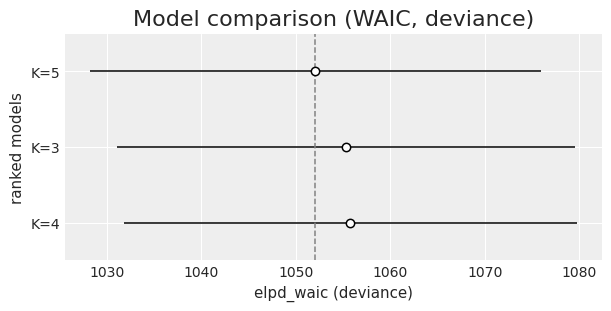

=== LOO (deviance) — mai mic = mai bun ===


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
K=5,0,1052.469537,24.236407,0.000000,0.578584,24.501471,0.000000,False,deviance
K=3,1,1055.380870,14.829304,2.911333,0.314801,24.541501,5.572049,False,deviance
K=4,2,1055.977527,23.555940,3.507990,0.106615,24.589616,1.643496,False,deviance


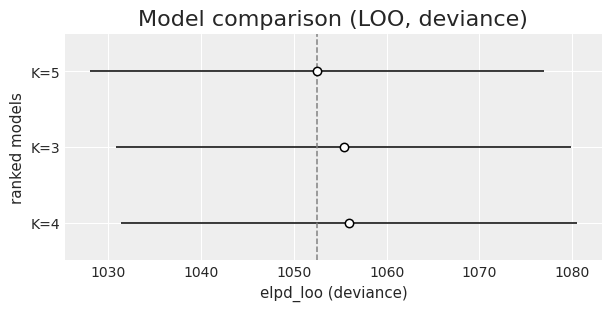

Best by WAIC: K=5
Best by LOO : K=5


In [8]:
for K in Ks:
    pm.compute_log_likelihood(idatas[K], model=models[K])

idata_dict = {f"K={K}": idatas[K] for K in Ks}

cmp_waic = az.compare(idata_dict, ic="waic", method="BB-pseudo-BMA", scale="deviance")
cmp_loo  = az.compare(idata_dict, ic="loo",  method="BB-pseudo-BMA", scale="deviance")

print("=== WAIC (deviance) — mai mic = mai bun ===")
display(cmp_waic)
az.plot_compare(cmp_waic)
plt.title("Model comparison (WAIC, deviance)")
plt.show()

print("=== LOO (deviance) — mai mic = mai bun ===")
display(cmp_loo)
az.plot_compare(cmp_loo)
plt.title("Model comparison (LOO, deviance)")
plt.show()

print("Best by WAIC:", cmp_waic.index[0])
print("Best by LOO :", cmp_loo.index[0])


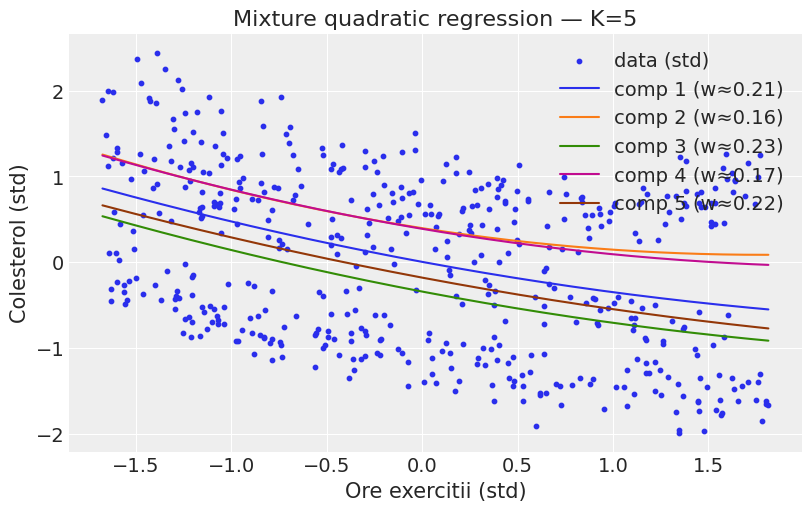

In [9]:
best_key = cmp_waic.index[0]
best_K = int(best_key.split("=")[1])
post = idatas[best_K].posterior.stack(sample=("chain","draw"))

w_m = post["w"].mean("sample").values
a_m = post["alpha"].mean("sample").values
b_m = post["beta"].mean("sample").values
g_m = post["gamma"].mean("sample").values

xg = np.linspace(x.min(), x.max(), 250)
xg2 = xg**2

plt.figure(figsize=(8,5))
plt.scatter(x, y, s=10, label="data (std)")

for k in range(best_K):
    yg = a_m[k] + b_m[k]*xg + g_m[k]*xg2
    plt.plot(xg, yg, label=f"comp {k+1} (w≈{w_m[k]:.2f})")

plt.title(f"Mixture quadratic regression — {best_key}")
plt.xlabel("Ore exercitii (std)")
plt.ylabel("Colesterol (std)")
plt.legend()
plt.show()
